# <u>If only Ben's Omnitrix had Machine Learning inbuilt?</u>
<strong> Imagine if the Omnitrix was capable of automatically turning Ben into the alien with the highest possibility of defeating the enemy</strong>

In [871]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import tensorflow_datasets as tfds

In [872]:
# loading the data
df = pd.read_csv("Ben_10_Data_Set.csv")

In [873]:
df.head()

,Character,Power_Level,Ben_10_Series
0,YOUNG MAX,39.5,Ben 10: Classic
1,VILGAX,80,Ben 10: Classic
2,BEN TENNYSON,4,Ben 10: Classic
3,GWEN TENNYSON,7,Ben 10: Classic
4,GRANDPA MAX,17.2,Ben 10: Classic


## Let us turn all the categorical into labels
<strong> We will initialize a LabelEncoder to achieve this. </strong>

In [874]:
lr = LabelEncoder()

def convert_id_to_category(index, mapping=None):
    """
        Convert the id into the label
        Arguments:
            mappping: The Mapping built by the LabelEncoder
            id: id corresponding to the label
        Returns:
            str: the label
    """
    return mapping.get(index, False)

def convert_to_mapping(lr:LabelEncoder):
    """
        Extract the mapping from the LabelEncoder
        
        Returns:
            Dict: key/value for the label encoded
    """
    mapping = dict(list(zip(lr.transform(lr.classes_),lr.classes_)))
    return mapping


def get_power_level_mapping(df=None):
    mapping = {}
    for i in range(0, len(df)):
        mapping[df.loc[i].Character] = df.loc[i].Power_Level
    vtok = {}
    for i,j in enumerate(mapping):
        vtok[mapping[j]] = j
    return mapping, vtok

# Ben_10_Series
df['Ben_10_Series'] = lr.fit_transform(df['Ben_10_Series'])
mapping_ben_10_series = convert_to_mapping(lr)
df['Character'] = lr.fit_transform(df['Character'])
mapping_character = convert_to_mapping(lr)

print ("Length [Ben_10_Series]: {}".format(len(mapping_ben_10_series)))
print ("Length [Character]: {}".format(len(mapping_character)))
        

Length [Ben_10_Series]: 4
Length [Character]: 90


In [877]:
df['Power_Level']

0                            39.5
1                              80
2                               4
3                               7
4                            17.2
                 ...             
92                            520
93    NORMAL = 12.5, FACE = 1,340
94                            336
95                          2,177
96      1,080,000,000,000,000,000
Name: Power_Level, Length: 97, dtype: object

In [875]:
df.head()

,Character,Power_Level,Ben_10_Series
0,89,39.5,1
1,77,80,1
2,10,4,1
3,39,7,1
4,32,17.2,1


#### <strong> Categorized data </strong>
- All category labels have been turned to numbers

## <u>Data Cleaning</u>

In [878]:
def remove_string_powerlevel(df=None):
    """
        Replaces the string format of power level into an integer. (Manually checked the data)
        
        Arguments:
            df: Pandas DataFrame
        Returns
            None
    """
    
    # lowe bound
    df.loc[28, "Power_Level"] = "265"
    df.loc[93, "Power_Level"] = "12.5"
    df.loc[51, "Power_Level"] = "195"
    df.loc[52, "Power_Level"] = "160"
    df.loc[62, "Power_Level"] = "140"
    df.loc[67, "Power_Level"] = "20"
    df['Power_Level'] = df['Power_Level'].str.replace(",","")
    
    # converting power_level to float
    df['Power_Level'] = df['Power_Level'].astype(float)
    df['Character'] = df['Character'].astype(int)
    

remove_string_powerlevel(df)

- Power_Level contained some uncleaned values (string)
- Power_Level contained values in string
- Power_Level contained commas

<AxesSubplot:>

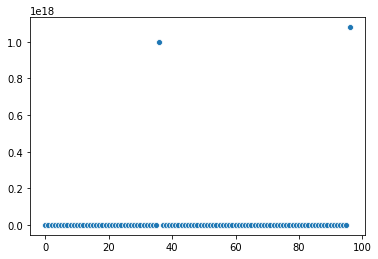

In [882]:
sns.scatterplot(data=df['Power_Level'].values)

- Now our data is cleaned, we will start by doing some feature transformation

# Feature Transformation
- In addition to feature transformations, we will create a new dataset capable of handling multiclass classification problems.
- To see where we can apply feature transformations, we will first check for any outliers.

In [771]:
np.random.seed(42)

def split_powerlevel(df, factor=3):
    """
        Split the power level by the specified factor
        Arguments:
            df:DataFrame
            factor: int
        Returns:
            data: dict[str] = list[str]
            
    """
    data = {'air_power1':[], 'sand_power1':[], 'water_power1':[], "air_power2":[], "sand_power2":[], "water_power2":[]}
    for i in df['power_level1']:
        t = i/factor # float
        data['air_power1'].append(t)
        data['sand_power1'].append(t)
        data['water_power1'].append(t)
    for i in df['power_level2']:
        t = i/factor # float
        data['air_power2'].append(t)
        data['sand_power2'].append(t)
        data['water_power2'].append(t)
    return data


def create_data(df, split_size=0.2, size=1000):
    """
        Create Data for Multiclass classification problem
        Arguments:
            df: Pandas DataFrame
        Returns:
            data: Pandas DataFrame
    """
    def return_individual_data(th = .5, winner='c1'):
        """
            Returns a row in our dataset.
            
            Arguments:
                th: threshold
                winner: The winning character
                
            Returns:
                (str,str, float, float, str)
        """
        characters = np.array(list(mapping_character.keys()))
        mapping_ch_to_pl, mapping_pl_to_ch = get_power_level_mapping(df)
        random_character1 = np.random.choice(characters)
        random_character2 = np.random.choice(characters)
        p1 = mapping_ch_to_pl[random_character1]
        p2 = mapping_ch_to_pl[random_character2]
        power_diff = np.abs(mapping_ch_to_pl[random_character1] - mapping_ch_to_pl[random_character2])
        if winner == 'c1':
            return random_character1, random_character2,p1, p2, random_character1
        else:
            return random_character1, random_character2,p1, p2, random_character2

            

    # win is by character1 (by default)
    data = {'character1':[], 'character2':[], 'power_level1':[],'power_level1':[],'power_level2':[], 'win':[]}
    
    # first half
    for i in range(0, size//2):
        c1, c2, p1, p2, c1 = return_individual_data(winner='c1')
        data['character1'].append(c1)
        data['character2'].append(c2)
        data['power_level1'].append(p1)
        data['power_level2'].append(p2)
        data['win'].append(c1)
    
    # second half
    for i in range(0, size//2):
        c1, c2, p1, p2, c2 = return_individual_data(winner='c2')
        data['character1'].append(c1)
        data['character2'].append(c2)
        data['power_level1'].append(p1)
        data['power_level2'].append(p2)
        data['win'].append(c2)
    
    data_df = pd.DataFrame(data=data, columns=['character1', 'character2', 'power_level1', 'power_level2', 'win'])
    data_df = shuffle(data_df)
    
    toadd = split_powerlevel(data_df)
    for k,v in enumerate(toadd):
        data_df[v] = toadd[v]
    
    features, labels = data_df.drop(columns=['win']).values, data_df.win.values
    
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
    
    
    print ("Generated data of size:{}".format(size))

    return features, labels,x_train, x_test, y_train, y_test,x_val, y_val, data_df


In [ ]:
df['Power_Level'] = np.log(df['Power_Level'])

- We can clearly see that there are two outliers and the obvious way to check for outlieris to analyze thresholds.

In [ ]:
sns.lineplot(data=df['Power_Level'].values)

- Log Transformation of the data of outliers.

In [ ]:
df['Power_Level'].var()

In [ ]:
values = df['Power_Level'].values

- If we set the threshold as the mean of the zscore values, we can clearly see all the outliers that are True.
- Now we do not want to remove the values as each character is essential.
- If we view the scatterplot of our data, we can clearly see the outlier very clearly.

In [ ]:
zscore(values, 0) > zscore(values, 0).mean()

- All the true values are the outliers.

In [ ]:
values[96] = np.mean(values)
values[36] = np.mean(values)
# changing the outliers to mean value
# handpicking abnormal values and setting it a justified value.

Mean: 5.397840428854952, Var: 3.2388358843830356, Std: 1.7996766054997313


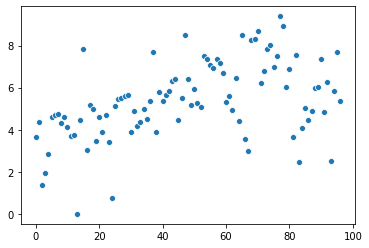

In [883]:
sns.scatterplot(data=values)
print ("Mean: {}, Var: {}, Std: {}".format(values.mean(), values.var(), values.std()))

- We can see that the data is not too distributed and all values closely align.

In [ ]:
df['Power_Level'] = values

In [857]:
def count_wins(df=None):
    """
        Count number of character wins.
        Returns:
            c1_wins: Character 1 wins
            c2_wins: Character 2 wins
    """
    for i in range(0, len(df)):
        if df.loc[i].character1 == df.loc[i].win:
            c1_wins.append(i)
        else:
            c2_wins.append(i)
    print("Character 1 wins: {}, Character 2 wins: {}".format(len(c1_wins), len(c2_wins)))       
    
features, labels,x_train, x_test, y_train, y_test,x_val, y_val,data = create_data(df, size=5000)

Generated data of size:5000


In [786]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

LogisticRegression(max_iter=10000)

In [793]:
rf = RandomForestClassifier(n_estimators=10000)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10000)

In [795]:
rf.score(x_test, y_test)

0.355

In [858]:
count_wins(data)

Character 1 wins: 4037, Character 2 wins: 3963


In [704]:
len(np.where(data.character1 == data.win)[0])

505

In [707]:
len(labels)

-495

In [859]:
# model
from sklearn.preprocessing import MinMaxScaler
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs")
EarlyStopping = tf.keras.callbacks.EarlyStopping(patience=3)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, activation='relu', input_dim=10))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(200, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(200, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(90, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

In [860]:
history = model.fit(x_train, y_train, epochs=300, validation_data=(x_val, y_val), callbacks=[tensorboard])

Epoch 1/300
94/94 [==============================] - 1s 6ms/step - loss: 9.7800 - acc: 0.0113 - val_loss: 4.5090 - val_acc: 0.0110
Epoch 2/300
94/94 [==============================] - 0s 3ms/step - loss: 5.5607 - acc: 0.0130 - val_loss: 4.4949 - val_acc: 0.0170
Epoch 3/300
94/94 [==============================] - 0s 3ms/step - loss: 4.9805 - acc: 0.0100 - val_loss: 4.4935 - val_acc: 0.0210
Epoch 4/300
94/94 [==============================] - 0s 3ms/step - loss: 4.7351 - acc: 0.0120 - val_loss: 4.4932 - val_acc: 0.0150
Epoch 5/300
94/94 [==============================] - 0s 3ms/step - loss: 4.6627 - acc: 0.0147 - val_loss: 4.4960 - val_acc: 0.0130
Epoch 6/300
94/94 [==============================] - 1s 8ms/step - loss: 4.5986 - acc: 0.0127 - val_loss: 4.4959 - val_acc: 0.0130
Epoch 7/300
94/94 [==============================] - 0s 5ms/step - loss: 4.5918 - acc: 0.0197 - val_loss: 4.4960 - val_acc: 0.0100
Epoch 8/300
94/94 [==============================] - 0s 3ms/step - loss: 4.5500 - a

In [828]:
rf.score(x_test, y_test)

0.345

In [890]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 100)               1100      
_________________________________________________________________
dropout_51 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 200)               20200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_53 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 90)              

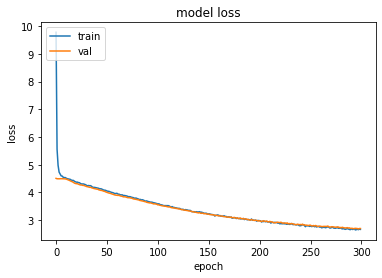

In [861]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 301)

plot_history(history)

In [863]:
def test():
    for i, j in enumerate(model.predict(x_test[0].reshape(1,-1))[0]):
        print ("{} -> {}".format(mapping_character[i], j))

        
test()

AGGREGOR -> 4.203285397692824e-13
ALIEN X -> 1.5128327193400515e-12
AMPFIBIAN -> 5.55081823807777e-15
ARMODRILLO -> 5.7059777042178794e-11
ARTIGUANA -> 3.1705682523863743e-09
ASTRODACTYLE -> 1.996169939413872e-12
ATOMIC X -> 6.816132014364484e-08
ATOMIX -> 1.3011019291297998e-05
BALL WEEVIL -> 4.928316360965166e-15
BEN TEN THOUSAND -> 1.1854661696730773e-10
BEN TENNYSON -> 1.581889509655451e-15
BIG CHILL -> 1.2278659596631769e-05
BLOXX (INDESTRUCTIBLE) -> 2.0889871166218654e-07
BRAINSTORM -> 3.942162948078476e-06
BULLFRAG -> 0.0008464688435196877
BUZZSHOCK -> 2.6531442927080207e-05
CANNONBOLT -> 0.011027975007891655
CHARMCASTER -> 0.0056919618509709835
CHROMOSTONE -> 0.02730976790189743
CRASHHOPPER -> 0.00017758151807356626
DARKSTAR -> 0.0004205204895697534
DIAGON -> 0.07080186158418655
DIAMONDHEAD -> 0.07565552741289139
DNALIEN -> 6.342388303437474e-08
ECHOECHO -> 4.924354470858816e-06
EON -> 0.31206458806991577
EON'S MINIONS -> 7.751674996336888e-11
FEEDBACK -> 0.0021991869434714317


In [575]:
return_individual_data()

(59, 26, 5.298317366548036, 2.995732273553991, 59)

In [557]:
vtok = {}
ktov = get_power_level_mapping(df)

In [577]:
ktov[26]

2.995732273553991

In [582]:
np.where(df['Character'] == df['Character'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),)